Energy with dietary fibre, equated \n(kJ)        9.92
Calcium (Ca) \n(mg)                              9.92
Energy, without dietary fibre, equated \n(kJ)    9.92
Potassium (K) \n(mg)                             9.92
Moisture (water) \n(g)                           9.92
Nitrogen \n(g)                                   9.84
Magnesium (Mg) \n(mg)                            9.84
Sodium (Na) \n(mg)                               9.84
Phosphorus (P) \n(mg)                            9.84
Zinc (Zn) \n(mg)                                 9.84
Protein \n(g)                                    9.84
Ash \n(g)                                        9.84
Iron (Fe) \n(mg)                                 9.60
Niacin derived from tryptophan \n(mg)            9.60
Niacin derived equivalents \n(mg)                9.60
Tryptophan \n(mg)                                9.60
Fat, total \n(g)                                 9.20
Thiamin (B1) \n(mg)                              9.20
Riboflavin (B2) \n(mg)      

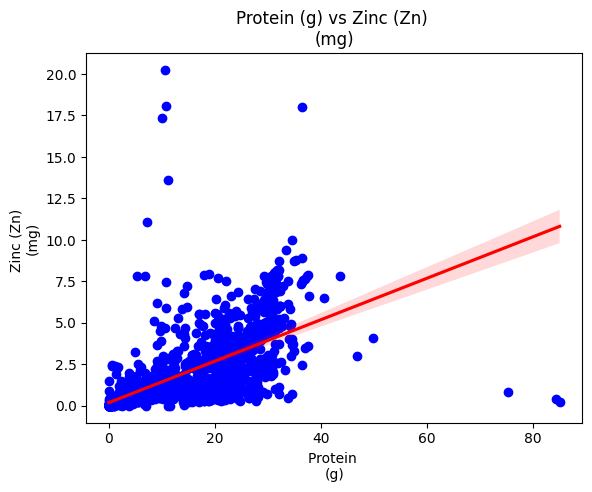

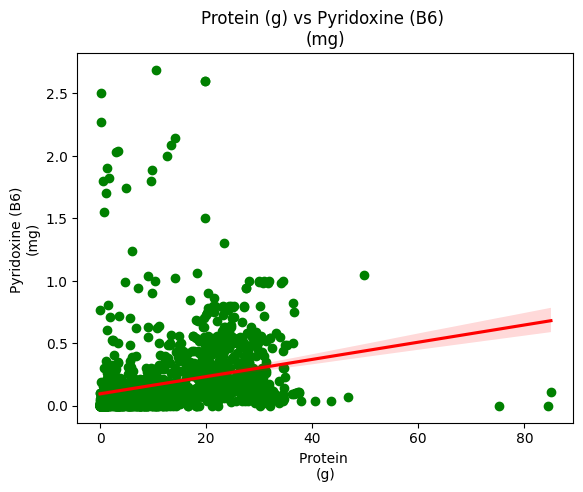

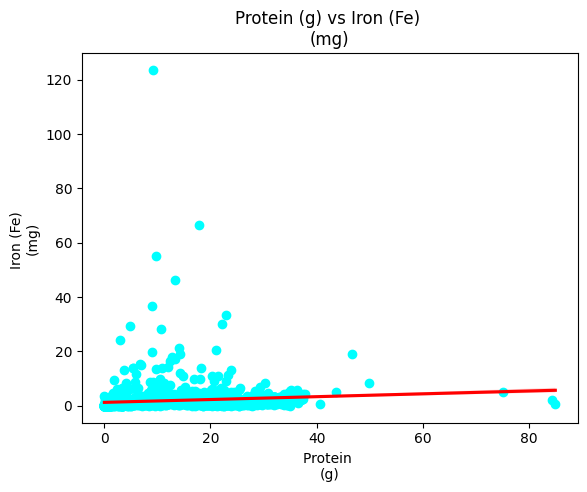

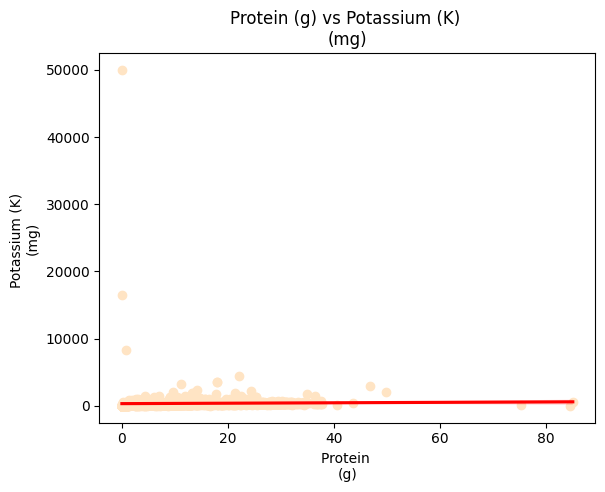

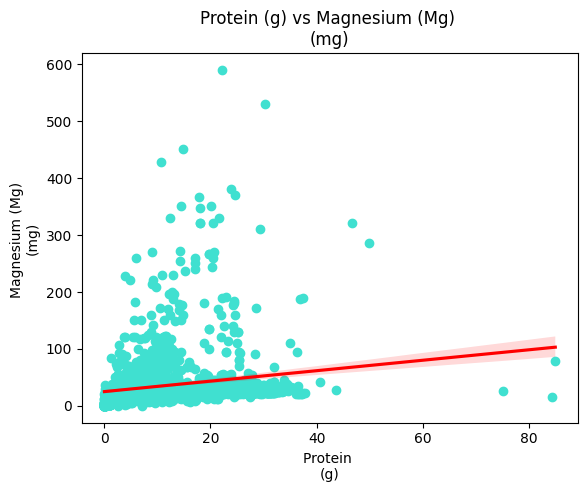

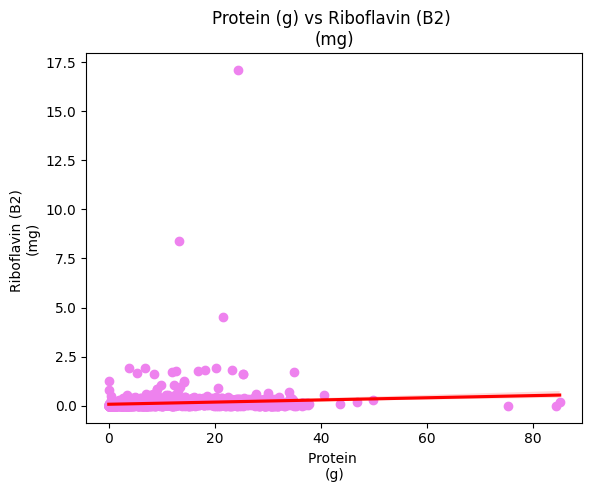

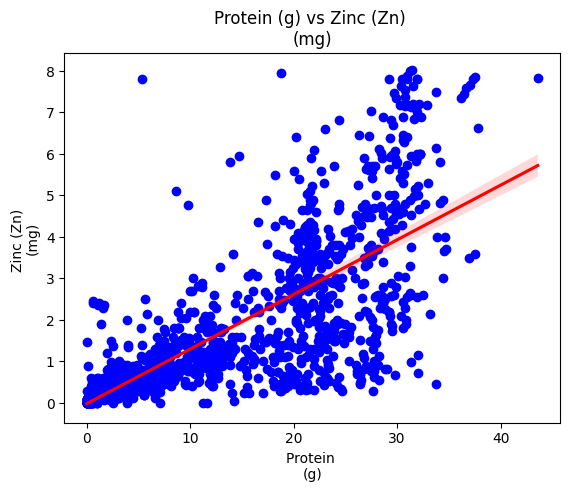

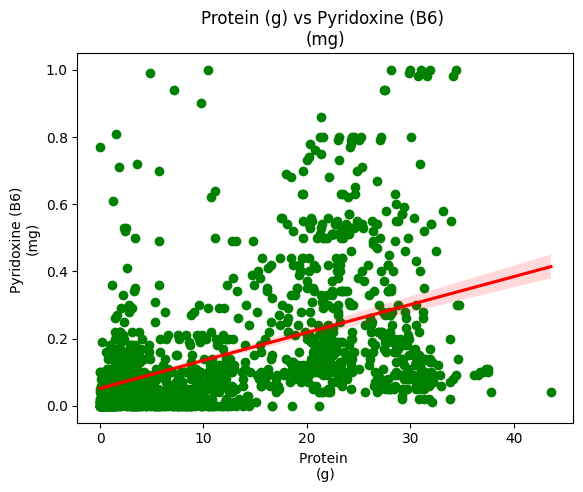

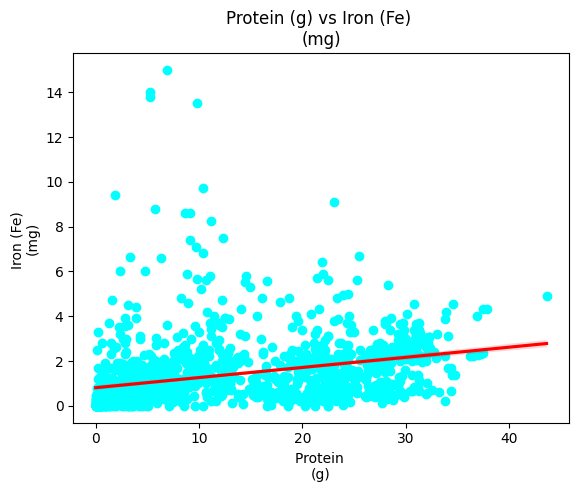

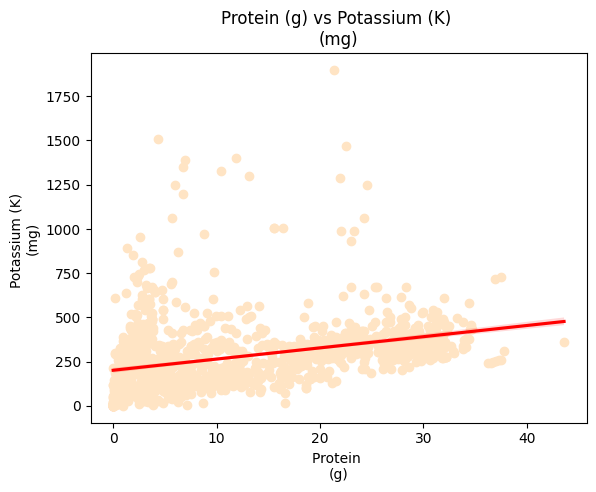

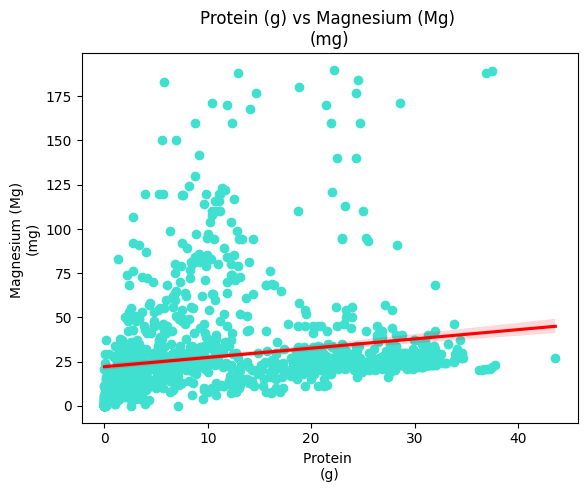

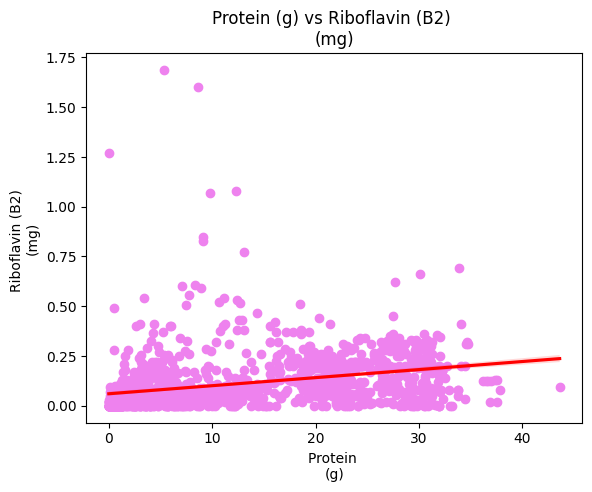

Pearson Correlation Coefficients:
Zinc (Zn) \n(mg)          0.772848
Pyridoxine (B6) \n(mg)    0.467158
Iron (Fe) \n(mg)          0.329974
Potassium (K) \n(mg)      0.359124
Magnesium (Mg) \n(mg)     0.205229
Riboflavin (B2) \n(mg)    0.323212
dtype: float64


NameError: name 'regressio' is not defined

In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats


# Read the Excel file (aka. sp|readsheet)
file_path = 'nutrient-file-release2-jan22.xlsx'
# The table is in the sheet: 'All solids & liquids per 100g'
data = pd.read_excel(file_path, sheet_name='All solids & liquids per 100g')

# Setting the names of the nutirnts we intend to predict
data_scaled_name = ['Zinc (Zn) \n(mg)','Pyridoxine (B6) \n(mg)', 'Iron (Fe) \n(mg)', 'Potassium (K) \n(mg)', 'Magnesium (Mg) \n(mg)', 'Riboflavin (B2) \n(mg)']

# only wants data after the third column because the first three columns are not nutrients
data = data.iloc[:, 3:]

# drop the column 'Protein \n(g)' because it is the topic we want to study
# data = data.drop(columns=['Protein \n(g)'])

# calculate the missing value ratio
missing_ratios = data.isnull().sum() / len(data)

# calculate the zero value ratio
zero_ratios = (data == 0).sum() / len(data)


# score
scores = pd.Series(0, index=data.columns)


# Calculate scores for the current nutrient
for column in data.columns:
    # 1. missing value ratio
    # for missing values: ==0% + 6, <1.0% + 5.85, <2.0% + 5.55, <5% + 5.15, <10% + 4.15, <20% + 2.15, other no score bonus
    if missing_ratios[column] == 0:
        scores[column] += 6.00
    elif 0 < missing_ratios[column] < 0.01:
        scores[column] += 5.85
    elif 0.01 < missing_ratios[column] < 0.02:
        scores[column] += 5.55
    elif 0.02 < missing_ratios[column] < 0.05:
        scores[column] += 5.15
    elif 0.05 < missing_ratios[column] < 0.1:
        scores[column] += 4.15
    elif 0.1 < missing_ratios[column] < 0.2:
        scores[column] += 2.15

    # 2. zero ratio
    # for zero values: <40% + 1.6, <30% + 2.4, <20% + 3.2, <10% + 3.6, <5% + 3.84, <2% + 3.92, =0 + 4 other no score bonus
    if 0.3 <= zero_ratios[column] < 0.4:
        scores[column] += 1.60
    elif 0.2 <= zero_ratios[column] < 0.3:
        scores[column] += 2.40
    elif 0.1 <= zero_ratios[column] < 0.2:
        scores[column] += 3.20
    elif 0.05 <= zero_ratios[column] < 0.1:
        scores[column] += 3.60
    elif 0.02 <= zero_ratios[column] < 0.05:
        scores[column] += 3.84
    elif 0.0 < zero_ratios[column] < 0.02:
        scores[column] += 3.92
    elif zero_ratios[column] == 0:
        scores[column] += 4.00

# get scores
scores = scores[scores > 9].sort_values(ascending=False)
print(scores)

# select the data with these high scores
data = data[scores.index]

# Drop rows with missing values
data.dropna(inplace=True)

# Calculate the Pearson correlation coefficient before removing outlier
X = data.drop(columns=['Protein \n(g)'])
y = data['Protein \n(g)']

# Calculate the Pearson correlation coefficients before removing outlier
correlation_coeffs = X.corrwith(y)

# Print the correlation coefficients before removing outlier
print("Pearson Correlation Coefficients before removing outliers:")
print(correlation_coeffs[data_scaled_name])

# Plot the graph before removing outliers
for name, color in zip(data_scaled_name, ['blue', 'green', 'cyan', 'bisque', 'turquoise', 'violet']):  
    plt.scatter(data[['Protein \n(g)']], data[[name]], color=color)
    
    # Add the line of best fit
    sns.regplot(data=data, x='Protein \n(g)', y=name, color= 'red', scatter=False)

    plt.xlabel('Protein \n(g)')
    plt.ylabel(name)
    plt.title(f'Protein (g) vs {name}')
    plt.show()

# Remove outliers using Z-Score method
z_scores = np.abs(stats.zscore(data))
threshold = 3
data = data[(z_scores < threshold).all(axis=1)]

# Plot the graph after removing outliers
for name, color in zip(data_scaled_name, ['blue', 'green', 'cyan', 'bisque', 'turquoise', 'violet']):  
    # Plot the scatter plot and the line of regression (MSE)
    plt.scatter(data[['Protein \n(g)']], data[[name]], color=color)

    # Add the line of best fit
    sns.regplot(data=data, x='Protein \n(g)', y=name, color= 'red', scatter=False)

    plt.xlabel('Protein \n(g)')
    plt.ylabel(name)
    plt.title(f'Protein (g) vs {name}')
    plt.show()

# Initialize a MinMaxScaler, because out of all kinds of stardardizations, MinMaxScaler(aka normalization) is the most suitable for this data as for example the nutrient some of it is mg, some is g, and some g is very spread out some is very concentrated
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame so that it's easier to work with and plot
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Correlation Matrix
cor = data_scaled[data_scaled_name].corr()

# Split the data into features (X) and target (y)
X = data_scaled.drop(columns=['Protein \n(g)'])
y = data_scaled['Protein \n(g)']

# Calculate the Pearson correlation coefficients after removing outlier
correlation_coeffs = X.corrwith(y)

# Print the correlation coefficients after removing outlier
print("Pearson Correlation Coefficients after removing outliers:")
print(correlation_coeffs[data_scaled_name])

# Only the protein data, only create a new dataframe with the protein and currewnt nutrient column
protein_data = data_scaled[['Protein \n(g)']]

# define a 5-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store the results
training_r2 = []
test_r2 = []
cv_r2 = []
cv_mse = []
regression_mse = []
# Loop through each nutrient to fit a linear regression model.
for name,color in zip(data_scaled_name,  ['blue', 'green', 'cyan', 'bisque', 'turquoise', 'violet']):
    for column in data_scaled[[name]].columns:
        # Skip 'Protein \n(g)' itself
        if column == 'Protein \n(g)':
            continue

        # the current nutrient data
        nutrient_data = data_scaled[column].dropna()

        # Combine protein and current nutrient data
        combined_data = pd.concat([protein_data, nutrient_data], axis=1)

        # Split the data into training and testing data, training size 80%, test 20%
        train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state = 62)

        # Define the training data
        X_train = train_data[['Protein \n(g)']]
        y_train = train_data[column]

        # Define the testing data
        X_test = test_data[['Protein \n(g)']]
        y_test = test_data[column]

        # Fit the model to the training data
        model = LinearRegression().fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Calculate R^2 scores
        training_r2.append(model.score(X_train, y_train))
        test_r2.append(model.score(X_test, y_test))

        # Perform cross-validation and compute scores
        cv_r2_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        cv_mse_scores = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')

        # Append Cross validation R^2 and MSE
        cv_r2.append(np.mean(cv_r2_scores))
        cv_mse.append(np.mean(cv_mse_scores))

        # Append the regression MSE
        regression_mse.append(mean_squared_error(y_test, predictions))
        # Calculate residuals
        residuals = y_test - predictions

        # Plot the scatter plot and the line of regression (MSE)
        plt.scatter(X_test, residuals, color= color)
        plt.axhline(y=0, color='red', linestyle='--')
        plt.xlabel('Protein \n(g)')
        plt.ylabel('Residuals')
        plt.title(f'Residual Plot for {column}')
        plt.show()

        # Plot the scatter plot and the line of regression (MSE)
        plt.scatter(X_test, y_test, color= color, label='Actual')
        plt.plot(X_test, predictions, color='red', label='Prediction')
        plt.xlabel('Protein \n(g)')
        plt.ylabel(column)
        plt.title(f'Test set scatter plot for {column}')
        plt.legend()
        plt.show()

        # Print the results
        print(f"R-squared: Protein (g) for {column}: {test_r2[-1]}")
        print(f"Cross-validated R-squared: Protein (g) for {column}: {cv_r2[-1]}")
        print(f"Cross-validated MSE: Protein (g) for {column}: {cv_mse[-1]}")
        print('MSE of the linear model trained only by the feature: Protein (g):', mean_squared_error(y_test, predictions))

    
# Print the results
print(f"R-squared training:{np.mean(training_r2)}")
print(f"R-squared testing: {np.mean(test_r2)}")
print(f"Cross-validated R-squared:{np.mean(cv_r2)}")
print(f"Cross-validated MSE:{np.mean(cv_mse)}")
print(f"Regression MSE:{np.mean(regression_mse)}")